# Группа лс -  токсичные комментарии
## Выполнили: студенты группы ПИ21-2В

Комментарии будут <font color='green'>зелеными</font>, <font color='blue'>синими</font> или <font color='red'>красными</font> :

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

Будет очень хорошо, если Вы будете помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

In [ ]:
!pip install scikit-optimize
!pip install skorch
!pip install optuna

In [2]:
# Подключаем фреймворк pytorch для глубокого обучения
import torch

# Используем для создания собственной модели классификации (Наследуем от nn.Model)
import torch.nn as nn

# Оптимизатор (В нашей работе при подборе параметров рассматривали SGD / Adam)
import torch.optim as optim

# Переводим предобработанные данные после векторизации в тензоры
from torch.utils.data import Dataset, DataLoader, TensorDataset

# библиотека с уже обученными моделями
import transformers

# Модели классификации и токенайзер, которые мы используем в работе
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Используем для работы с датасетом при предобработке, а также получения общей характеристики датасета
import pandas as pd

# база (массивы, генераторы, в общем, математические операции)
import numpy as np

# Используем методы этой библиотеки для обработки естественного языка
import nltk

# Используем в предобработке данных из датасета (регулярные выражения)
import re

# Используем stopwords для того чтобы убрать возможные неинофрмативные выбросы
from nltk.corpus import stopwords as nltk_stopwords

# Используем для токенизации в функции предобработки
from nltk.tokenize import word_tokenize

# Используем для стемминга слов на английском языке
# Было принято решение использовать лемматизацию вместо стемминга
# from nltk.stem.snowball import EnglishStemmer

# Используем для лемматезации (в функции предобработки) (повышение качества и точности)
from nltk.stem import WordNetLemmatizer

# Используем для векторизации строковых комментариев (Перевода их в численные векторные значения)
from sklearn.feature_extraction.text import TfidfVectorizer

# Используем как модель для предсказания оценки
from sklearn.linear_model import LogisticRegression

# Используем для получения оценки f1 на основе модели для линейных данных
from sklearn.svm import LinearSVC

# Используем для просмотра результатов работы наших моделей
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix

# Используем для разбивки выборок на тестовую и обучающую, подбора гиперпараметров, кроссвалидационную оценку и предсказание
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict

# Используем модель случайного леса для классификации
from sklearn.ensemble import RandomForestClassifier

# Используем модель градиентного спуска для классификации
from sklearn.linear_model import SGDClassifier

# Так как использование GridSearchCV занимало слишком много времени, попробуем также другие варианты оптимизации гиперпараметров
from skopt import BayesSearchCV

# Используем для получения гиперпараметров для BayesSearchCV
from skopt.space import Integer, Real

# from gensim.models import Word2Vec
# skorch - библиотека-обвязка между torch и sklearn (с ее помощью применяем gridsearch для нашей модели torch)
from skorch import NeuralNetClassifier, NeuralNet
from skorch.helper import SliceDataset
from skorch.callbacks import EpochScoring

# Используем данный фреймворк для отпимизации гиперпараметров модели библиотеки transformers
import optuna
from optuna.trial import Trial

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Подгружаем требуемые модули nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

<div class="alert alert-block alert-success"> <font color='green'>Успех</font>
 Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать Ваш ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

<div class="alert alert-block alert-success"> <font color='blue'>Совет</font>

# загрузим библиотеки
import torch

import transformers

import pandas as pd ✔

import numpy as np

import nltk

import re

from nltk.corpus import stopwords as nltk_stopwords

from nltk.stem.snowball import EnglishStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, f1_score

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_predict

<div class="alert alert-block alert-success"> <font color='blue'>Совет</font>

*Рекомендуется давать комментарии зачем импортируются библиотеки и модули*

In [4]:
# Наш финальный вариант функции предобработки датасета с лемматизацией (получили немного лучшую оценку)
def preprocess_text_advanced(text : str) -> str:
    '''
    Токенизация, удаление стоп слов, лемматизация
    '''
    text = text.lower()
    # удаление всех символов, кроме букв, '@', '#'
    text = re.sub(r'[^a-z@# ]', ' ', text)

    tokens = word_tokenize(text)
    stop_words = set(nltk_stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(lemmatized_tokens)

def prepare_data_advanced(filename: str) -> pd.DataFrame:
    '''
    Применение функции preprocess_text_advanced ко всем ячейкам text['text'] датасета
    '''
    text = pd.read_csv(f"{filename}.csv")
    text['text'] = text['text'].apply(preprocess_text_advanced)
    return text


In [7]:
# Получаем обработанные данные
text = prepare_data_advanced("toxic_comments")

In [ ]:
# Была использована также подвыборка для проверки работы кода (ускорение процесса для отладки)
text_sample = text.sample(frac=0.2, random_state=42)

In [ ]:
# Данные о датасете
print(f"_____10 первых строк_____\n{text.head(10)}\n")
print(f"_____Описательная статистика_____\n{text.describe()}")

_____10 первых строк_____
                                                text  toxic
0  explanation edits made username hardcore metal...      0
1  aww match background colour seemingly stuck th...      0
2  hey man really trying edit war guy constantly ...      0
3  make real suggestion improvement wondered sect...      0
4                      sir hero chance remember page      0
5             congratulation well use tool well talk      0
6                        cocksucker piss around work      1
7  vandalism matt shirvington article reverted pl...      0
8  sorry word nonsense offensive anyway intending...      0
9               alignment subject contrary dulithgow      0

_____Описательная статистика_____
               toxic
count  159571.000000
mean        0.101679
std         0.302226
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


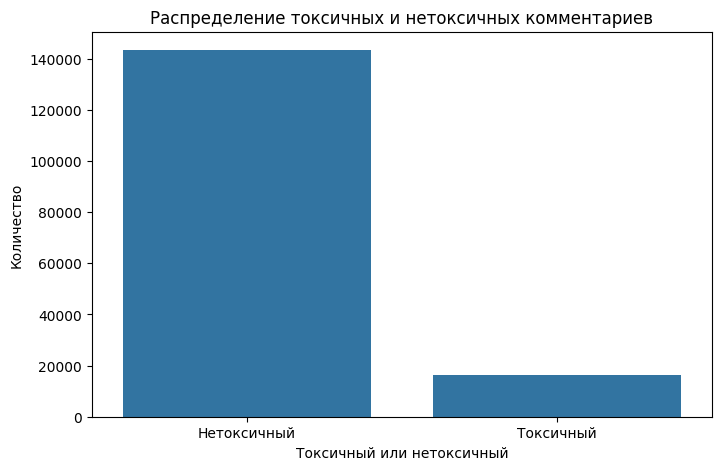

In [ ]:
# Распределение в датасете по оценкам
plt.figure(figsize=(8, 5))
sns.countplot(data=text, x='toxic', legend=False)
plt.title('Распределение токсичных и нетоксичных комментариев')
plt.xlabel('Токсичный или нетоксичный')
plt.ylabel('Количество')
plt.xticks([0, 1], ['Нетоксичный', 'Токсичный'])
plt.show()

In [ ]:
# Разбиваем на тестовую и тренировочную выборки и применяем векторизацию
X = text['text']
Y = text['toxic']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Преобразование текстовых комментариев в числовые векторы для обработки моделью
vectorizer = TfidfVectorizer()
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

In [ ]:
# ДЛЯ ПОДВЫБОРКИ (TEST)
# ================================================================================================================================
# Разбиваем на тестовую и тренировочную выборки и применяем векторизацию
X_sample = text['text']
Y_sample = text['toxic']
X_train_sample, X_test_sample, Y_train_sample, Y_test_sample = train_test_split(X_sample, Y_sample, test_size=0.2, random_state=42)

# Преобразование текстовых комментариев в числовые векторы для обработки моделью
vectorizer_sample = TfidfVectorizer()
X_train_sample = vectorizer_sample.fit_transform(X_train_sample)
X_test_sample = vectorizer_sample.transform(X_test_sample)
# ================================================================================================================================

In [ ]:
# Применение модели Linear Support Vector Classification
model_svc = LinearSVC(C=1., loss="squared_hinge", penalty="l2")
model_svc.fit(X_train_vector, Y_train)

svc_predict = model_svc.predict(X_test_vector)

f1_result_linear_svc = f1_score(Y_test, svc_predict)
as_result_linear_svc = accuracy_score(Y_test, svc_predict)
cross_val_result_linear_svc = cross_val_score(model_svc, X_train_vector, Y_train, cv=5)
cross_val_predict_linear_svc = cross_val_predict(model_svc, X_train_vector, Y_train, cv=5)
print(f"Итоговое значение оценки F1 для LinearSVC = {f1_result_linear_svc:.4f}")
print(f"Итоговое значение оценки AS для LinearSVC= {as_result_linear_svc:.4f}")
print(f"Итоговое значение оценки CrosAc для LinearSVC= {cross_val_result_linear_svc}")
print(f"Итоговое значение оценки CrosPred для LinearSVC= {cross_val_predict_linear_svc}")

Итоговое значение оценки F1 для LinearSVC = 0.7887
Итоговое значение оценки AS для LinearSVC= 0.9613
Итоговое значение оценки CrosAc для LinearSVC= [0.95899264 0.95875602 0.95793349 0.95934354 0.96044025]
Итоговое значение оценки CrosPred для LinearSVC= [1 0 0 ... 0 0 0]


In [ ]:
# Применение модели LogisticRegression
model_lr = LogisticRegression(C=10, max_iter=1000, penalty="l2")
model_lr.fit(X_train_vector, Y_train)

lr_predict = model_lr.predict(X_test_vector)

f1_result_lr = f1_score(Y_test, lr_predict)
as_result_lr = accuracy_score(Y_test, lr_predict)
cross_val_result_lr = cross_val_score(model_lr, X_train_vector, Y_train, cv=5)
cross_val_predict_lr = cross_val_predict(model_lr, X_train_vector, Y_train, cv=5)
print(f"Итоговое значение оценки F1 для LogisticRegression = {f1_result_lr:.4f}")
print(f"Итоговое значение оценки AS для LogisticRegression= {as_result_lr:.4f}")
print(f"Итоговое значение оценки CrosAc для LogisticRegression= {cross_val_result_lr}")
print(f"Итоговое значение оценки CrosPred для LogisticRegression= {cross_val_predict_lr}")

Итоговое значение оценки F1 для LogisticRegression = 0.7860
Итоговое значение оценки AS для LogisticRegression= 0.9610
Итоговое значение оценки CrosAc для LogisticRegression= [0.95860097 0.95793349 0.9571893  0.95922604 0.95918687]
Итоговое значение оценки CrosPred для LogisticRegression= [1 0 0 ... 0 0 0]


'\nПри использовании оптимизированных гиперпараметров получили лучшие оценки:\nF1     увеличилось с 0.7527 до 0.7890\nAS     увеличилось с 0.9576 до 0.9614\nCrosAC увеличилось с [0.95429265 0.9544867  0.95303748 0.95570091 0.95527006] до [0.95864014 0.95852101 0.95695429 0.96008774 0.95856018]\n'

In [ ]:
# Применение модели RandomForestClassifier
model_rfc = RandomForestClassifier(max_depth=None, max_features='sqrt', n_estimators=35, random_state=42)
model_rfc.fit(X_train_vector, Y_train)

rfc_predict = model_rfc.predict(X_test_vector)

f1_result_rfc = f1_score(Y_test, rfc_predict)
as_result_rfc = accuracy_score(Y_test, rfc_predict)
cross_val_result_rfc = cross_val_score(model_rfc, X_train_vector, Y_train, cv=5)
cross_val_predict_rfc = cross_val_predict(model_rfc, X_train_vector, Y_train, cv=5)
print(f"Итоговое значение оценки F1 для RFC = {f1_result_rfc:.4f}")
print(f"Итоговое значение оценки AS для RFC = {as_result_rfc:.4f}")
print(f"Итоговое значение оценки CrosAc для RFC = {cross_val_result_rfc}")
print(f"Итоговое значение оценки CrosPred для RFC = {cross_val_predict_rfc}")

Итоговое значение оценки F1 для RFC = 0.7113
Итоговое значение оценки AS для RFC = 0.9523
Итоговое значение оценки CrosAc для RFC = [0.94971017 0.95194078 0.94923818 0.95111825 0.9516666 ]
Итоговое значение оценки CrosPred для RFC = [1 0 0 ... 0 0 0]


In [ ]:
# Применение модели SGDClassifier
model_sgd = SGDClassifier(max_iter=1000, l1_ratio=0.1, loss='modified_huber', random_state=42)
model_sgd.fit(X_train_vector, Y_train)

sgd_predict = model_sgd.predict(X_test_vector)

f1_result_sgd = f1_score(Y_test, sgd_predict)
as_result_sgd = accuracy_score(Y_test, sgd_predict)
cross_val_result_sgd = cross_val_score(model_sgd, X_train_vector, Y_train, cv=5)
cross_val_predict_sgd = cross_val_predict(model_sgd, X_train_vector, Y_train, cv=5)
print(f"Итоговое значение оценки F1 для SGD = {f1_result_sgd:.4f}")
print(f"Итоговое значение оценки AS для SGD = {as_result_sgd:.4f}")
print(f"Итоговое значение оценки CrosAc для SGD = {cross_val_result_sgd}")
print(f"Итоговое значение оценки CrosPred для SGD = {cross_val_predict_sgd}")

Итоговое значение оценки F1 для SGD = 0.7428
Итоговое значение оценки AS для SGD = 0.9568
Итоговое значение оценки CrosAc для SGD = [0.95335266 0.95354667 0.95276331 0.95507422 0.95456504]
Итоговое значение оценки CrosPred для SGD = [1 0 0 ... 0 0 0]


## **Оценки моделей LinearSVC, LogisticRegression, RandomForestClassifier, SGDClassifier (на оптимизированных гиперпараметрах)**
###**LinearSVC**
####*Параметры:*
- LinearSVC(C=1., loss="squared_hinge", penalty="l2")

####*Оценки:*
- F1 = 0.7887
- Accuracy Score = 0.9613
- CrossVal Accuracy = [0.95899264 0.95875602 0.95793349 0.95934354 0.96044025]
- CrossVal Predict  = [1 0 0 ... 0 0 0]

###**LogisticRegression**
####*Параметры:*
- LogisticRegression(C=10, max_iter=1000, penalty="l2")

####*Оценки:*
- F1 = 0.7860
- Accuracy Score = 0.9610
- CrossVal Accuracy = [0.95860097 0.95793349 0.9571893  0.95922604 0.95918687]
- CrossVal Predict  = [1 0 0 ... 0 0 0]

###**RandomForestClassifier**
####*Параметры:*
- RandomForestClassifier(max_depth=None, max_features='sqrt', n_estimators=35, random_state=42)

####*Оценки:*
- F1 = 0.7113
- Accuracy Score = 0.9523
- CrossVal Accuracy = [0.94971017 0.95194078 0.94923818 0.95111825 0.9516666 ]
- CrossVal Predict  = [1 0 0 ... 0 0 0]
  
###**SGDClassifier**
####*Параметры:*
- SGDClassifier(max_iter=1000, l1_ratio=0.1, loss='modified_huber', random_state=42)
####*Оценки:*
- F1 = 0.7428
- Accuracy Score = 0.9568
- CrossVal Accuracy = [0.95335266 0.95354667 0.95276331 0.95507422 0.95456504]
- CrossVal Predict  = [1 0 0 ... 0 0 0]

## Оптимизация гиперпараметров моделей:

Дальнейшим действием будет
подбор подходящих параметров для моделей с их последующим обучением и использованием

Применим для этого будет GridSearchCV, BayesSearchCV

In [ ]:
# Словарь параметров для моделей
param_grid = {
    'LinearSVC': {
        'C'               : (0.01, 0.1, 1, 10),
        'penalty'         : ('l1', 'l2'),
        'loss'            : ('hinge', 'squared_hinge'),
    },
    'LogisticRegression'  : {
        'C'               : (0.01, 0.1, 1, 10),
        'penalty'         : ('l1', 'l2'),
        'max_iter'        : (10000, 20000, 50000, 100000),
    },
    'RandomForestClassifier': {
        'n_estimators'    : list(np.arange(1, 50)),
        'max_features'    : ('sqrt',),
        'max_depth'       : (None,),
        'random_state'    : (42,)
    },
    'SGDClassifier': {
        'alpha'           : (0.0001, 0.001, 0.01, 0.1),
        'loss'            : ('hinge', 'log_loss', 'modified_huber'),
    }
}

# Словарь моделей
models = {
    'LinearSVC': LinearSVC(),
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'SGDClassifier': SGDClassifier()
}

# Выполнение GridSearchCV для каждой модели
for model_name, model in models.items():
    scorer = make_scorer(f1_score)
    grid_search = GridSearchCV(model, param_grid[model_name], cv=3, scoring=scorer, verbose=10)
    grid_search.fit(X_train, Y_train)

    # Вывод результатов
    print(f"Лучшие параметры для {model_name}: {grid_search.best_params_}")
    print(f"Лучшая оценка F1: {grid_search.best_score_}")

In [ ]:
'''
Что было получено из GridSearchCV:
==================================================================================================
  Изначально с параметрами по умолчанию для этой модели мы получили f1_score = 0.7926
  ("С" по умолчанию : 1, "loss" по умолчанию : "squared_hinge", "penalty" по умолчанию : "l2")
  То есть через GridSearchCV f1_score с теми же параметрами стало ниже на 2%
- Лучшие параметры для LinearSVC:          {'C': 1, 'loss': 'squared_hinge', 'penalty': 'l2'}
- Лучшая оценка F1: 0.7719210977594392
==================================================================================================
- Лучшие параметры для LogisticRegression: {'C': 10, 'max_iter': 1000, 'penalty': 'l2'}
- Лучшая оценка F1: 0.766208706872744
==================================================================================================
- Лучшие параметры для RandomForestClassifier {'max_depth' : None, 'max_features' : 'sqrt', 'n_estimators' : 35, 'random_state' : 42}
- Лучшая оценка F1: 0.7079
==================================================================================================
- Лучшие параметры для SGDClassifier {'max_iter' : 1000, 'l1_ratio' : 0.1, 'loss' : 'modified_huber', 'random_state' : 42}
- Лучшая оценка F1: 0.7428
==================================================================================================
'''

In [ ]:
'''
Байесовская оптимизация — это метод, который сочетает вероятностные модели с методами оптимизации для эффективного поиска оптимальных гиперпараметров.
Он основан на идее моделирования функции оценки производительности модели и использования этой модели для выбора следующей точки для оценки.
Байесовская оптимизация часто требует меньше итераций, чем решетчатый или случайный поиск, чтобы достичь лучших результатов.
'''

In [ ]:
# Так как GridSearchCV на подвыборке (20% от датасета) ничего нам не дал, стоит попробовать другой вариант оптимизации гиперпараметров: skopt.BayesSearchCV
# Определение пространства поиска гиперпараметров
param_space = {
    'n_estimators': Integer(1, 10),
    'max_depth': Integer(3, 15),
    'min_samples_leaf': Integer(1, 4),
    'max_features': Real(0.1, 1.0, prior='uniform')
}

# Создание модели и настройка с использованием байесовской оптимизации
rf_model = RandomForestClassifier()
scorer = make_scorer(f1_score)
bayes_search = BayesSearchCV(rf_model, param_space, n_iter=50, cv=3, scoring=scorer)
bayes_search.fit(X_train_sample, Y_train_sample)

# Вывод наилучших гиперпараметров и оценки
print("Best Hyperparameters:", bayes_search.best_params_)
print("Best Cross-Validation Score:", bayes_search.best_score_)

- В результате использования BayesSearchCV на подвыборке (sample 20% от датасета) мы получили следующие гиперпараметры:
Best Hyperparameters: OrderedDict([('max_depth', 15), ('max_features', 0.20015244045013114), ('min_samples_leaf', 1), ('n_estimators', 5)])
Best Cross-Validation Score: 0.945005875440658

**Но в итоге дождались выполнения GridSearch и получили более подходящие параметры (в итогах выше)**

## **Реализация в PyTorch**
- создание модели
- подбор гиперпараметров
- обучение с полученными параметрами
- вывод значенией требуемых оценок

In [ ]:
X = text['text']
Y = text['toxic']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
'''
Что было сделано:
Ограничили max_features=5000, так как при запуске кода без параметра ломалась среда разработки
(Не хватало ОЗУ для обработки всех данных)

5000 - оптимальное полученное значение ограничения кол-во фичей
(При подборе параметров torch модели требует до 12.2gb ОЗУ из 12.7 доступных)
'''
vectorizer_torch = TfidfVectorizer(max_features=5000)
X_train_temp = vectorizer_torch.fit_transform(X_train)
X_test_temp = vectorizer_torch.transform(X_test)

**Преобразовали данные X в тензоры**

In [ ]:
X_train_temp = X_train_temp.toarray()
X_test_temp = X_test_temp.toarray()
# Преобразование TF-IDF матриц в тензоры PyTorch
X_train_tensor = torch.tensor(X_train_temp, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_temp, dtype=torch.float32)

# Преобразование данных Y_train, Y_test в тензоры
Y_train_tensor = torch.tensor(Y_train.values)
Y_test_tensor  = torch.tensor(Y_test.values)

# Создание TensorDataset для обучающего и тестового наборов
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# Создание DataLoader для обучающего и тестового наборов
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

**Создание модели**

In [ ]:
'''
Изначальный код архитектуры нашей torch модели классификации токсичных комментариев
Входной слой - Функция активации - Выходной слой
Выходной слой имеет два выхода - классы - в нашем случае два класса (токсичный / нетоксичный)
'''
# class ToxicClassificationModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(ToxicClassificationModel, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)  # Полносвязный слой
#         self.relu = nn.ReLU()  # Функция активации ReLU
#         self.fc2 = nn.Linear(hidden_size, num_classes)  # Выходной слой

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x

'''
Измененная версия архитектуры нашей torch модели классификации токсичных комментариев
Входной слой - Батч-нормализация - Функция активации - Регуляризация - Выходной слой

Что было  сделано:
1. Регуляризация: Добавили регуляризацию, такую как Dropout, чтобы предотвратить переобучение. Сделали, добавив nn.Dropout(0.5) между слоями. 0.5 - вероятность отключения нейрона
2. Батч-нормализация: Батч-нормализация для проверки ускорится ли обучение. Добавили nn.BatchNorm1d после полносвязных слоёв.
'''
class ToxicClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ToxicClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
X_train_tensor.shape[1]

5000

**Подбор гиперпараметров**

In [ ]:
# Оптимизация гиперпараметров нашей PyTorch модели в GridSearchCV через обвязку skorch
input_size = X_train_tensor.shape[1]  # Размер входного слоя (признаков)
hidden_size = 128  # Размер скрытого слоя
num_classes = 2  # Количество классов (токсичный, не токсичный)

model = ToxicClassificationModel(input_size, hidden_size, num_classes)
net = NeuralNetClassifier(
    model,
    criterion=nn.CrossEntropyLoss,
    max_epochs=10,
    lr=0.1,
    iterator_train__shuffle=True  # Перемешивание данных на каждой эпохе
)

params = {
    'max_epochs': [15, 30, 50],
    'criterion': [nn.CrossEntropyLoss],
    'optimizer': [optim.Adam, optim.SGD],
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='f1', verbose=10)

gs.fit(X_train_tensor, Y_train_tensor)
print(gs.best_score_, gs.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START criterion=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, max_epochs=15, optimizer=<class 'torch.optim.adam.Adam'>
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.2281       0.9433        0.1550  11.2445
      2        0.1770       0.9459        0.1535  14.6050
      3        0.1568       0.9478        0.1633  15.2631
      4        0.1503       0.9513        0.1501  15.4477
      5        0.1366       0.9492        0.1570  16.1688
      6        0.1309       0.9495        0.1691  15.4953
      7        0.1279       0.9518        0.1848  15.3920
      8        0.1273       0.9498        0.1678  15.3430
      9        0.1211       0.9489        0.1900  16.2845
     10        0.1194       0.9501        0.1660  15.6649
     11        0.1154       0.9529        0.1834  16.0678
     12        0.1123       0.9512        0.2122 

**Оптимальные значение гиперпараметров для нашей модели при hidden_size==128**
- criterion  : CrossEntropy
- max_epochs : 15
- optimizer  : SGD

Оценка F1 при этих параметрах = 0.7622625848235401

## **Итоговое значение оценки f1 и accuracy для PyTorch модели с подобранными гиперпараметрами:**
- f1  = 0.7557069846678024
- acc = 0.955068149772834


**Обучение и вывод требуемых оценок**

In [ ]:
input_size = X_train_tensor.shape[1]  # Размер входного слоя (признаков) (== 5000)
hidden_size = 128  # Размер скрытого слоя
num_classes = 2  # Количество классов (токсичный, не токсичный)

# Инициализация модели
model = ToxicClassificationModel(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

# Обучение модели
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Вычисление F1-score
f1 = f1_score(true_labels, predictions)
# Вычисление accuracy_score
acc_sc = accuracy_score(true_labels, predictions)
print(f'F1-score on test set: {f1}')
print(f'accuracy score on test set: {acc_sc}')

F1-score on test set: 0.7557069846678024
accuracy score on test set: 0.955068149772834


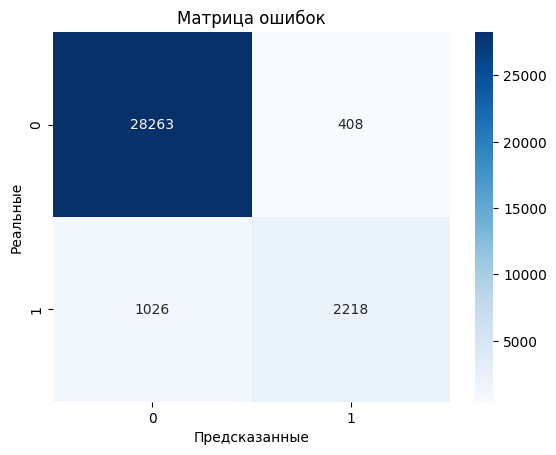

In [ ]:
'''
Построение матрицы ошибок (Confusion Matrix) для визуальной оценки результатов классификации
-----------
| TP | FP |
-----------
| FN | TN |
-----------
Из полученных результатов можно сделать выводы:
28263 истинно положительных результата
2218  истинно отрицательных результата
при 408 ложноположительных и 1026 ложноотрицательных говорит о том, что точность модели для данной задачи довольно высока

Однако большая неточность при классификации нетоксичных комментариев как токсичных (появление большого количества ложноотрицательных результатов)

Для сравнения это 3.63% ошибки для нетоксичных и 18.39% ошибок для токсичных
'''
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Предсказанные')
plt.ylabel('Реальные')
plt.title('Матрица ошибок')
plt.show()

## **Реализация с использованием библиотеки transformers**

In [ ]:
'''
Что было сделано:
(При работе на cpu)
1. Используем DistilBertTokenizer, DistilBertForSequenceClassification вместо BertTokenizer, BertForSequenceClassification
так как они менее требовательны к ресурсам системы (судя по источнику, который нашли)
2. Ограничиваем максимальную длину входного текста, так как без ограничения опять же расходуется весь доступный объем ОЗУ,
из-за чего сбрасывается среда разработки

Также не была изначально применена векторизация, так как tokenizer принимает на вход текстовые данные,
а далее мы уже переводим все в тензоры (и DataLoader) для обучения модели на наших данных

(При работе на gpu)
Был использован фреймворк optuna для оптимизации гиперпараметров (обучение - 3 эпохи, всего итераций оптимизации - 10)
Но ресурсы gpu на аккаунте кончились, из двух проделанных итераций получили лучший результат:
оценка f1 = 0.8077399380804954
parameters: {'learning_rate': 5.562135787126372e-05, 'batch_size': 64}
'''

In [8]:
X = text['text']
Y = text['toxic']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [9]:
def prepare_data_to_train_transformers_model(X_train: pd.core.series.Series,
                                             X_test:  pd.core.series.Series,
                                             Y_train: pd.core.series.Series,
                                             Y_test:  pd.core.series.Series) -> tuple:
    '''
    Подготовка данных для модели:
    Предварительная обработка и токенизация текста
    Возвращает кортеж с двумя элементами типа torch.Dataloader (для тренировочных и тестовых данных)
    '''
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    X_train_str = list(map(str, X_train.values))
    X_test_str = list(map(str, X_test.values))

    train_encodings = tokenizer(X_train_str, truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(X_test_str, truncation=True, padding=True, max_length=128)

    # Переводим значения в вид TensorDataset для передачи аргументов:
    train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                                  torch.tensor(train_encodings['attention_mask']),
                                  torch.tensor(Y_train.values))
    test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                                torch.tensor(test_encodings['attention_mask']),
                                torch.tensor(Y_test.values))

    # Инициализация DataLoader
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    return train_loader, test_loader

train_loader, test_loader = prepare_data_to_train_transformers_model(X_train, X_test, Y_train, Y_test)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
!nvidia-smi

Fri Apr 19 06:39:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Оптимизация гиперпараметров с использованием фреймворка optuna

# Подключаем GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-4, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Переносим все тензоры на GPU с CPU (Тензоры хранятся на одном устройстве device)
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Обучение модели
    num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        for input_ids, attention_mask, labels in train_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

    # Вычисление метрик на валидационных данных
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    f1 = f1_score(true_labels, predictions)
    return f1

# Устанавливаем максимизацию нашей оценки f1
study = optuna.create_study(direction='maximize')
# Запускаем оптимизацию с отображением статуса выполнения (всего 10 итераций)
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Вывод лучших показателей
best_params = study.best_params
best_trial = study.best_trial
print("Best trial:", best_trial)
print("Best hyperparameters:", best_params)

In [ ]:
'''
Результаты, полученные после оптимизации гиперпараметров модели из библиотеки transformers при помощи фреймворка optuna:

f1 = 0.8077399380804954
parameters: {'learning_rate': 5.562135787126372e-05, 'batch_size': 64}
'''

In [ ]:
# Подключаем GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Переносим все тензоры на GPU с CPU (Тензоры хранятся на одном устройстве device) (При условии, что используем GPU)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5.562135787126372e-05)
criterion = nn.CrossEntropyLoss()

'''
Подготовка тренировочных и тестовых данных для модели
'''
train_loader, test_loader = prepare_data_to_train_transformers_model(X_train, X_test, Y_train, Y_test)

'''
Обучение модели DistilBertForSequenceClassification на тренировочном TensorDataset
'''
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for input_ids, attention_mask, labels in train_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

'''
Получение оценок с использованием обученной ранее модели DistilBertForSequenceClassification
'''
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

'''
Результаты
'''
f1_result = f1_score(true_labels, predictions)
as_result = accuracy = accuracy_score(true_labels, predictions)

# Кросс-валидация (оценка)
f1_scores = cross_val_score(model, X_train_tensor, Y_train_tensor, cv=5, scoring="f1")
accuracy_scores = cross_val_score(model, X_train_tensor, Y_train_tensor, cv=5, scoring="accuracy")
# Кросс-валидация (предсказание)
predictions = cross_val_predict(model, X_train_tensor, Y_train_tensor, cv=5)

print(f"F1 на тестовой выборке: {f1_result:.4f}")
print(f"AS на тестовой выборке: {as_result:.4f}")

print(f"F1 кросс-валидация: {f1_scores}")
print(f"AS кросс-валидация: {accuracy_scores}")
print(f"Предсказание кросс-валидация: {predictions}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Итоговое значение оценки f1 для DistilBertForSequenceClassification - модели из библиотеки transformers с подобранными гиперпараметрами:**
- f1  = 0.8077399380804954

